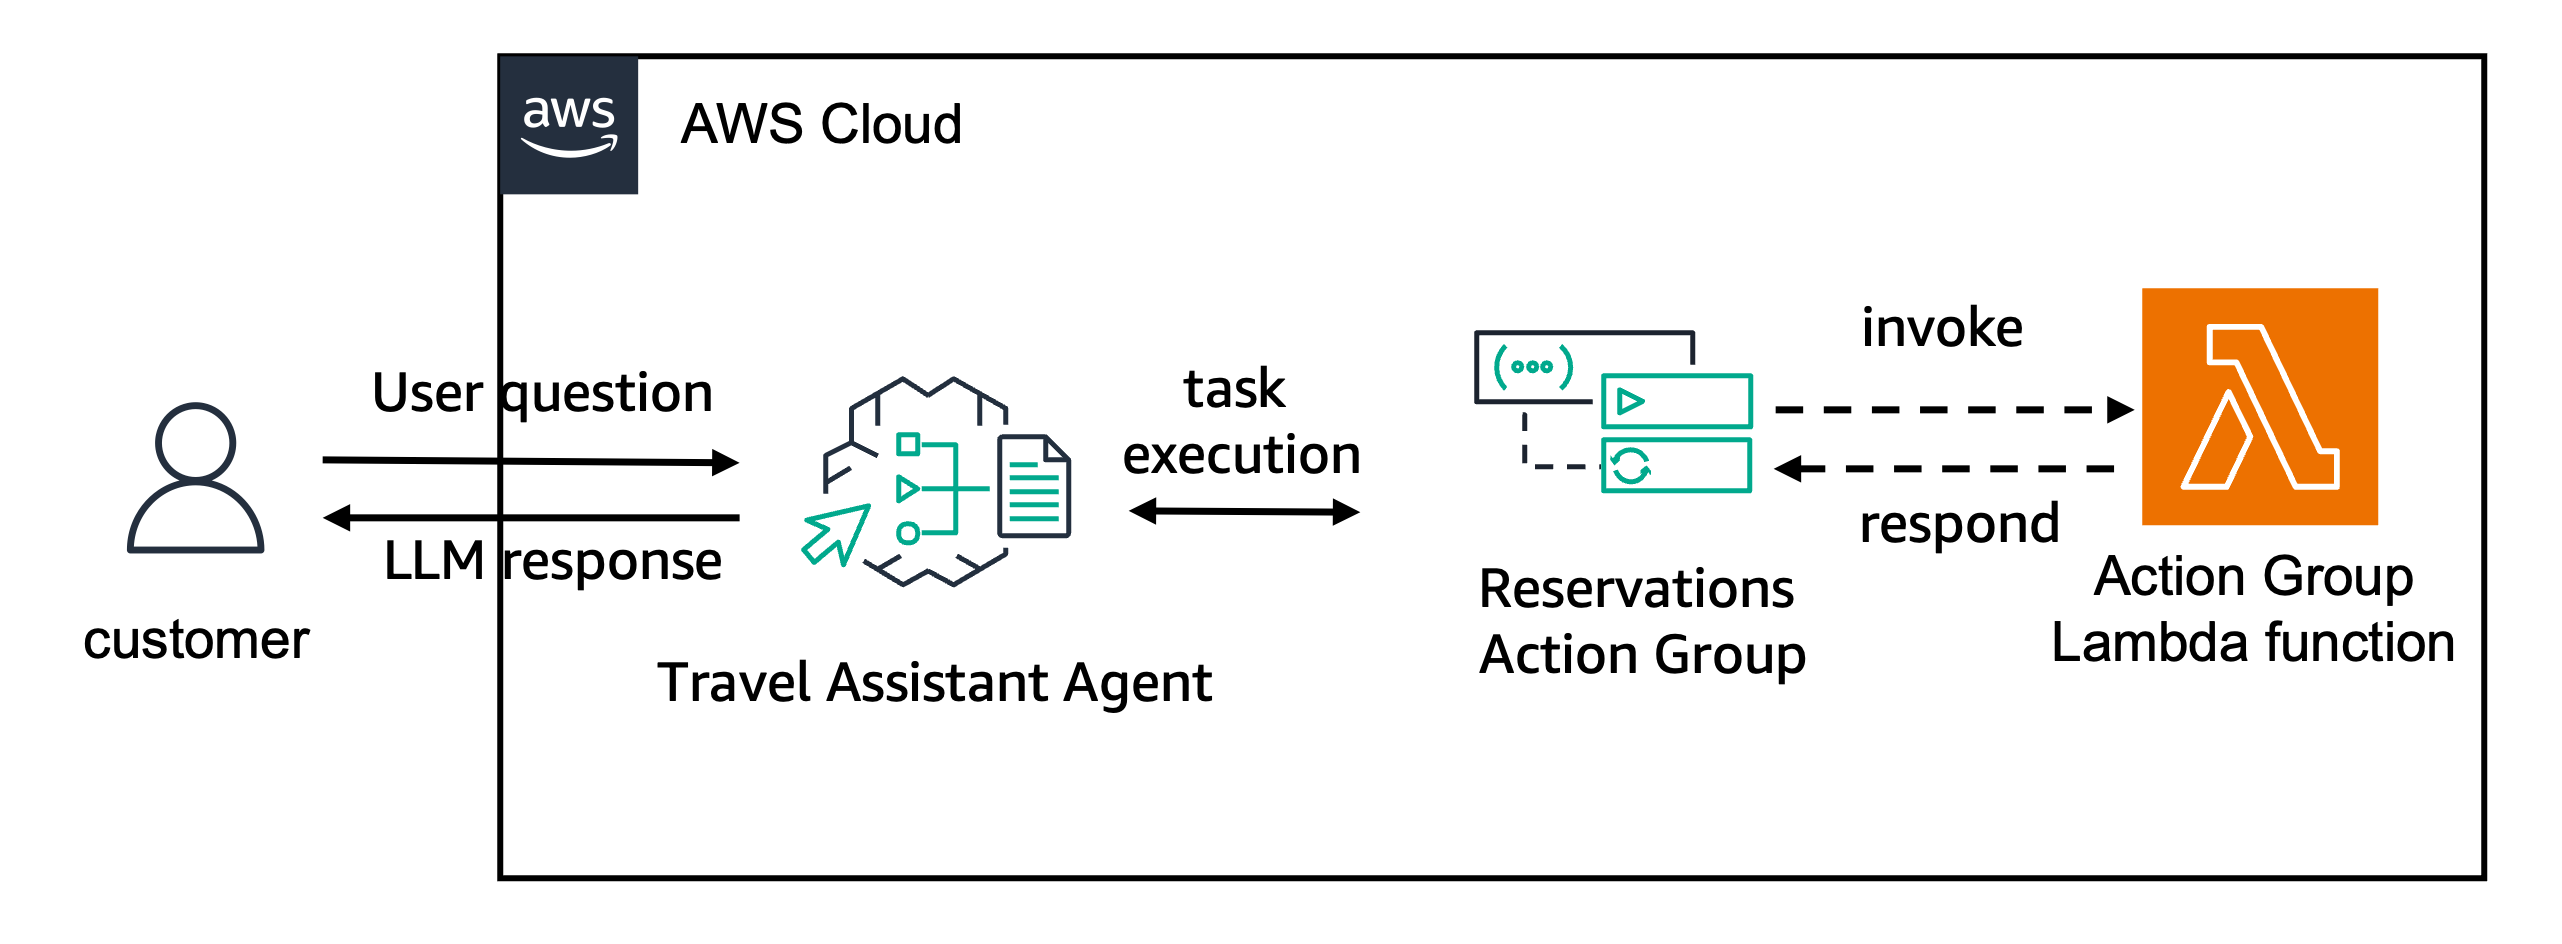

In [1]:
import boto3
import botocore
import awscli
print(boto3.__version__)
print(botocore.__version__)
print(awscli.__version__)

1.38.24
1.38.24
1.40.23


In [2]:
import json
import time
import uuid
import pprint
import logging
from io import BytesIO
import zipfile

In [3]:
# setting logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
# get boto3 clients for AWS services
sts_client = boto3.client('sts')
iam_client = boto3.client('iam')
lambda_client = boto3.client('lambda')
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime')

[2025-06-01 12:30:38,163] p42610 {credentials.py:1352} INFO - Found credentials in shared credentials file: ~/.aws/credentials


In [5]:
session = boto3.session.Session()
region = session.region_name
account_id = sts_client.get_caller_identity()['Account']
region, account_id

('us-east-1', '442120074911')

In [6]:
# configuration variables
suffix = f"{region}-{account_id}"
agent_name = "travel-assistant-with-memory"
agent_bedrock_allow_policy_name = f"{agent_name}-ba-{suffix}"
agent_role_name = f"AmazonBedrockExecutionRoleForAgents_{agent_name}"
agent_foundation_model = "amazon.nova-pro-v1:0"
agent_description = "Agent for providing travel assistance to manage trip reservations"
agent_instruction = """
You are a travel agency assistant that helps customers make reservations.
You can create, update or delete travel reservations
"""
agent_action_group_name = "BookingManagerActionGroup"
agent_action_group_description = """
Action group to manage travel bookings. It allows you to create, update or delete train and air travel reservations
"""
agent_alias_name = f"{agent_name}-alias"
lambda_function_role = f"{agent_name}-lambda-role-{suffix}"
lambda_function_name = f"{agent_name}-{suffix}"
memory_time = 30 # 30 days of memory

In [8]:
%%writefile lambda_function.py
import json
import uuid
import boto3

def get_named_parameter(event, name):
    """
    Get a parameter from lambda event
    """
    return next(item for item in event['parameters'] if item['name'] == name)['value']

def book_trip(origin, destination, start_date, end_date, transportation_mode):
    """
    Book a trip and return booking_id
    """
    booking_id = str(uuid.uuid4())[:8]
    return f"Successfully booked trip from {origin}({start_date}) to {destination}({end_date}) via {transportation_mode}. Booking ID is {booking_id}"


def populate_function_response(event, response_body):
    return {
        'response':{
            'actionGroup': event['actionGroup'],
            'function': event['function'],
            'functionResponse':{
                'responseBody': {
                    'TEXT': {
                        'body': response_body
                    }
                }
            }
        }
    }

def update_existing_trip_dates(booking_id, new_start_date, new_end_date):
    return f"Successfully updated trip details for booking_id {booking_id} with start_date {new_start_date} and end_date {new_end_date}"


def delete_existing_trip_reservation(booking_id):
    return f"Successfully cancelled reservation for booking_id {booking_id}"


def lambda_handler(event, context):
    # get action group, function and parameters
    actionGroup = event.get('actionGroup', '')
    function = event.get('function', '')
    parameters = event.get('parameters', [])

    if function == "update_existing_trip_dates":
        booking_id = get_named_parameter(event, "booking_id")
        new_start_date = get_named_parameter(event, "new_start_date")
        new_end_date = get_named_parameter(event, "new_end_date")
        if booking_id and new_start_date and new_end_date:
            response = update_existing_trip_dates(booking_id, new_start_date, new_end_date)
            result = json.dumps(response)
        else:
            result = "Missing required parameters"
    
    elif function == "book_trip":
        origin = get_named_parameter(event, "origin")
        destination = get_named_parameter(event, "destination")
        start_date = get_named_parameter(event, "start_date")
        end_date = get_named_parameter(event, "end_date")
        transportation_mode = get_named_parameter(event, "transportation_mode")

        if origin and destination and start_date and end_date and transportation_mode:
            response = book_trip(origin, destination, start_date, end_date, transportation_mode)
            result = json.dumps(response)
        
        else:
            result = "Missing required parameters"
    
    elif function == "delete_existing_trip_reservation":
        booking_id = get_named_parameter(event, "booking_id")
        
        if booking_id:
            response = delete_existing_trip_reservation(booking_id)
            result = json.dumps(response)
        else:
            result = "Missing booking_id"
    
    else:
        result = "Invalid Function"
    
    action_response = populate_function_response(event, result)

    print(action_response)

    return action_response

Overwriting lambda_function.py


In [9]:
# Create IAM Role for the Lambda function
try:
    assume_role_policy_document = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow",
                "Principal": {
                    "Service": "lambda.amazonaws.com"
                },
                "Action": "sts:AssumeRole"
            }
        ]
    }
    

    assume_role_policy_document_json = json.dumps(assume_role_policy_document)

    lambda_iam_role = iam_client.create_role(
        RoleName=lambda_function_role,
        AssumeRolePolicyDocument=assume_role_policy_document_json
    )

    # Pause to make sure role is created
    time.sleep(10)
except:
    lambda_iam_role = iam_client.get_role(RoleName=lambda_function_role)

iam_client.attach_role_policy(
    RoleName=lambda_function_role,
    PolicyArn='arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole'
)

{'ResponseMetadata': {'RequestId': '5faca1be-c981-4823-9cb2-266ed766eeda',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sun, 01 Jun 2025 07:34:03 GMT',
   'x-amzn-requestid': '5faca1be-c981-4823-9cb2-266ed766eeda',
   'content-type': 'text/xml',
   'content-length': '212'},
  'RetryAttempts': 0}}

In [10]:
# Package up Lambda Function
s = BytesIO()
z = zipfile.ZipFile(s, 'w')
z.write('lambda_function.py')
z.close()
zip_content = s.getvalue()

lambda_function = lambda_client.create_function(
    FunctionName=lambda_function_name,
    Runtime='python3.12',
    Timeout=180,
    Role=lambda_iam_role['Role']['Arn'],
    Code={'ZipFile': zip_content},
    Handler='lambda_function.lambda_handler'
)

#### Create Agent

In [11]:
# Create IAM policies for agent
bedrock_agent_bedrock_allow_policy_statement = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "AmazonBedrockAgentBedrockFoundationModelPolicy",
            "Effect": "Allow",
            "Action": "bedrock:InvokeModel",
            "Resource": [
                f"arn:aws:bedrock:{region}::foundation-model/{agent_foundation_model}"
            ]
        }
    ]
}

bedrock_policy_json = json.dumps(bedrock_agent_bedrock_allow_policy_statement)

agent_bedrock_policy = iam_client.create_policy(
    PolicyName=agent_bedrock_allow_policy_name,
    PolicyDocument=bedrock_policy_json
)

In [12]:
# Create IAM Role for the agent and attach IAM policies
assume_role_policy_document = assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [{
          "Effect": "Allow",
          "Principal": {
            "Service": "bedrock.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
    }]
}

assume_role_policy_document_json = json.dumps(assume_role_policy_document)
agent_role = iam_client.create_role(
    RoleName=agent_role_name,
    AssumeRolePolicyDocument=assume_role_policy_document_json
)

# Pause to make sure role is created
time.sleep(10)
    
iam_client.attach_role_policy(
    RoleName=agent_role_name,
    PolicyArn=agent_bedrock_policy['Policy']['Arn']
)

{'ResponseMetadata': {'RequestId': '522ad8f5-7aa1-43aa-8c5d-a8b2e5961535',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sun, 01 Jun 2025 10:13:36 GMT',
   'x-amzn-requestid': '522ad8f5-7aa1-43aa-8c5d-a8b2e5961535',
   'content-type': 'text/xml',
   'content-length': '212'},
  'RetryAttempts': 0}}

#### Creating the agent with memory configuration

In [13]:
response = bedrock_agent_client.create_agent(
    agentName=agent_name,
    agentResourceRoleArn=agent_role['Role']['Arn'],
    description=agent_description,
    idleSessionTTLInSeconds=1800,
    foundationModel=agent_foundation_model,
    instruction=agent_instruction,
    memoryConfiguration={
        "enabledMemoryTypes": ["SESSION_SUMMARY"],
        "storageDays": 30
    }
)
response

{'ResponseMetadata': {'RequestId': '0b4860bf-8c1f-4daa-991f-7b80d46f2769',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Sun, 01 Jun 2025 10:17:13 GMT',
   'content-type': 'application/json',
   'content-length': '828',
   'connection': 'keep-alive',
   'x-amzn-requestid': '0b4860bf-8c1f-4daa-991f-7b80d46f2769',
   'x-amz-apigw-id': 'LetKfGcnIAMEALQ=',
   'x-amzn-trace-id': 'Root=1-683c28a9-25d714eb6f9aafb362ed4d6f'},
  'RetryAttempts': 0},
 'agent': {'agentArn': 'arn:aws:bedrock:us-east-1:442120074911:agent/P3CIIRFLBO',
  'agentCollaboration': 'DISABLED',
  'agentId': 'P3CIIRFLBO',
  'agentName': 'travel-assistant-with-memory',
  'agentResourceRoleArn': 'arn:aws:iam::442120074911:role/AmazonBedrockExecutionRoleForAgents_travel-assistant-with-memory',
  'agentStatus': 'CREATING',
  'createdAt': datetime.datetime(2025, 6, 1, 10, 17, 13, 316146, tzinfo=tzutc()),
  'description': 'Agent for providing travel assistance to manage trip reservations',
  'foundationModel': 'amazon.nova-p

In [14]:
agent_id = response['agent']['agentId']
agent_id

'P3CIIRFLBO'

#### Create Agent Action Group

In [15]:
# define function schema
agent_functions = [
    {
        'name': 'book_trip',
        'description': 'book a trip for a customer',
        'parameters': {
            "origin": {
                "description": "city of origin for the trip",
                "required": True,
                "type": "string"
            },
            "destination": {
                "description": "city of destination for the trip",
                "required": True,
                "type": "string"
            },
            "start_date": {
                "description": "the start date for the trip in the format YYYY-MM-DD",
                "required": True,
                "type": "string"
            },
            "end_date": {
                "description": "the end date for the trip in the format YYYY-MM-DD",
                "required": True,
                "type": "string"
            },
            "transportation_mode": {
                "description": "the transportation mode. One of TRAIN or AIR",
                "required": True,
                "type": "string"
            }
        }
    },
    {
        'name': 'update_existing_trip_dates',
        'description': 'update start or end date for an existing trip reservation',
        'parameters': {
            "booking_id": {
                "description": "the id of the trip to update",
                "required": True,
                "type": "integer"
            },
            "new_start_date": {
                "description": "the new start date for the trip in the format YYYY-MM-DD",
                "required": True,
                "type": "string"
            },
            "new_end_date": {
                "description": "the new end date for the trip in the format YYYY-MM-DD",
                "required": True,
                "type": "string"
            }
        }
    },
    {
        'name': 'delete_existing_trip_reservation',
        'description': 'delete an existing trip reservation',
        'parameters': {
            "booking_id": {
                "description": "the id of the trip to update",
                "required": True,
                "type": "integer"
            }
        }
    }
]

In [16]:
# Pause to make sure agent is created
time.sleep(30)

In [17]:

# Now, we can configure and create an action group here:
agent_action_group_response = bedrock_agent_client.create_agent_action_group(
    agentId=agent_id,
    agentVersion='DRAFT',
    actionGroupExecutor={
        'lambda': lambda_function['FunctionArn']
    },
    actionGroupName=agent_action_group_name,
    functionSchema={
        'functions': agent_functions
    },
    description=agent_action_group_description
)

In [18]:
agent_action_group_response

{'ResponseMetadata': {'RequestId': 'f999de8c-58f7-4369-a46a-39fce22abc52',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sun, 01 Jun 2025 10:20:10 GMT',
   'content-type': 'application/json',
   'content-length': '1940',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'f999de8c-58f7-4369-a46a-39fce22abc52',
   'x-amz-apigw-id': 'LetmFFF2IAMEV0w=',
   'x-amzn-trace-id': 'Root=1-683c2959-624c89a7395c8b273c0c6b40'},
  'RetryAttempts': 0},
 'agentActionGroup': {'actionGroupExecutor': {'lambda': 'arn:aws:lambda:us-east-1:442120074911:function:travel-assistant-with-memory-us-east-1-442120074911'},
  'actionGroupId': 'B2L3MI3MIM',
  'actionGroupName': 'BookingManagerActionGroup',
  'actionGroupState': 'ENABLED',
  'agentId': 'P3CIIRFLBO',
  'agentVersion': 'DRAFT',
  'createdAt': datetime.datetime(2025, 6, 1, 10, 20, 9, 865769, tzinfo=tzutc()),
  'description': '\nAction group to manage travel bookings. It allows you to create, update or delete train and air travel reservations\n'

#### Allowing Agent to invoke Action Group Lambda


In [19]:
# Create allow invoke permission on lambda
response = lambda_client.add_permission(
    FunctionName=lambda_function_name,
    StatementId='allow_bedrock',
    Action='lambda:InvokeFunction',
    Principal='bedrock.amazonaws.com',
    SourceArn=f"arn:aws:bedrock:{region}:{account_id}:agent/{agent_id}",
)

In [20]:
response

{'ResponseMetadata': {'RequestId': '7bf66f25-c31d-4504-8d60-15058312a4a2',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Sun, 01 Jun 2025 10:21:17 GMT',
   'content-type': 'application/json',
   'content-length': '379',
   'connection': 'keep-alive',
   'x-amzn-requestid': '7bf66f25-c31d-4504-8d60-15058312a4a2'},
  'RetryAttempts': 0},
 'Statement': '{"Sid":"allow_bedrock","Effect":"Allow","Principal":{"Service":"bedrock.amazonaws.com"},"Action":"lambda:InvokeFunction","Resource":"arn:aws:lambda:us-east-1:442120074911:function:travel-assistant-with-memory-us-east-1-442120074911","Condition":{"ArnLike":{"AWS:SourceArn":"arn:aws:bedrock:us-east-1:442120074911:agent/P3CIIRFLBO"}}}'}

#### Preparing Agent

In [21]:
response = bedrock_agent_client.prepare_agent(
    agentId=agent_id
)
print(response)

{'ResponseMetadata': {'RequestId': '436b0153-79a8-41d9-a72b-d20dcdfde09d', 'HTTPStatusCode': 202, 'HTTPHeaders': {'date': 'Sun, 01 Jun 2025 10:21:45 GMT', 'content-type': 'application/json', 'content-length': '119', 'connection': 'keep-alive', 'x-amzn-requestid': '436b0153-79a8-41d9-a72b-d20dcdfde09d', 'x-amz-apigw-id': 'Let1AEMUoAMEALQ=', 'x-amzn-trace-id': 'Root=1-683c29b9-3fb5b80b3993317414bfc0c6'}, 'RetryAttempts': 0}, 'agentId': 'P3CIIRFLBO', 'agentStatus': 'PREPARING', 'agentVersion': 'DRAFT', 'preparedAt': datetime.datetime(2025, 6, 1, 10, 21, 45, 474188, tzinfo=tzutc())}


In [22]:
# Pause to make sure agent is prepared
time.sleep(30)

# Extract the agentAliasId from the response
agent_alias_id = "TSTALIASID"

In [23]:
def invoke_agent_helper(
    query, session_id, agent_id, alias_id, enable_trace=False, memory_id=None, session_state=None, end_session=False
):
    if not session_state:
        session_state = {}

    # invoke the agent API
    agent_response = bedrock_agent_runtime_client.invoke_agent(
        inputText=query,
        agentId=agent_id,
        agentAliasId=alias_id,
        sessionId=session_id,
        enableTrace=enable_trace,
        endSession=end_session,
        memoryId=memory_id,
        sessionState=session_state
    )

    if enable_trace:
        logger.info(pprint.pprint(agent_response))

    event_stream = agent_response['completion']
    try:
        for event in event_stream:
            if 'chunk' in event:
                data = event['chunk']['bytes']
                if enable_trace:
                    logger.info(f"Final answer ->\n{data.decode('utf8')}")
                agent_answer = data.decode('utf8')
                return agent_answer
                # End event indicates that the request finished successfully
            elif 'trace' in event:
                if enable_trace:
                    logger.info(json.dumps(event['trace'], indent=2))
            else:
                raise Exception("unexpected event.", event)
    except Exception as e:
        raise Exception("unexpected event.", e)

#### What happening inside bedrock agent on invocation
1.	Input Parsing:
Parses your inputText (e.g., "How do I cancel my flight?").

2.	Plan Generation (Optional):
If the agent is configured with tools/functions (like Lambda, Knowledge Base, etc.), it may generate a plan to execute a tool before calling the LLM.

3.	Tool Execution (Optional):
Executes external tools (e.g., Lambda function) based on the plan.

4.	LLM Invocation:
Finally, it sends the constructed prompt to an LLM behind the scenes (like Anthropic Claude or Amazon Titan), along with any tool results and memory.

5.	Streaming the Output:
The response from the LLM is streamed back chunk-by-chunk through the completion field.

#### Starting conversation with empty memory


In [24]:
## create a random id for session initiator id
session_id:str = str(uuid.uuid1())
memory_id:str = 'TST_MEM_ID'
enable_trace:bool = False
end_session:bool = False
query = "Hi, my name is Tony. I would like to book a trip from Boston to NYC departuring on July 11th 2024 and returning on July 22nd 2024. Via AIR."
invoke_agent_helper(query, session_id, agent_id, agent_alias_id, enable_trace=enable_trace, memory_id=memory_id)

'Tony, your trip from Boston to NYC departing on July 11th, 2024, and returning on July 22nd, 2024, via AIR has been successfully booked. Your booking ID is 02a712ee. If you need any further assistance, feel free to ask.'

In [25]:
query = "thank you!"
invoke_agent_helper(query, session_id, agent_id, agent_alias_id, enable_trace=enable_trace, memory_id=memory_id)

"You're welcome, Tony! If you have any more questions or need further assistance, please let me know. Enjoy your trip!"

In [26]:
query = "end"
invoke_agent_helper(query, session_id, agent_id, agent_alias_id, enable_trace=enable_trace, memory_id=memory_id, end_session=True)

"Session is terminated as 'endSession' flag is set in request."

In [27]:
# support function that waits until the memory has been created
def wait_memory_creation(agent_id, agent_alias_id, memory_id):
    start_memory=time.time()
    memory_content = None
    if memory_id is not None:
        while not memory_content:
            time.sleep(5)
            memory_content=bedrock_agent_runtime_client.get_agent_memory(
                agentAliasId=agent_alias_id,
                agentId=agent_id,
                memoryId=memory_id,
                memoryType='SESSION_SUMMARY'
            )['memoryContents']
        end_memory=time.time()
        memory_creation_time=(end_memory-start_memory)
    return memory_creation_time, memory_content

In [28]:
wait_memory_creation(agent_id, agent_alias_id, memory_id)

(6.55386209487915,
 [{'sessionSummary': {'memoryId': 'TST_MEM_ID',
    'sessionExpiryTime': datetime.datetime(2025, 6, 1, 10, 40, 34, 787000, tzinfo=tzutc()),
    'sessionId': 'befaee5c-3ed4-11f0-9cb7-b69f39c16bf4',
    'sessionStartTime': datetime.datetime(2025, 6, 1, 10, 39, 52, 192000, tzinfo=tzutc()),
    'summaryText': ' Tony wants to book a trip from Boston to NYC departing on July 11th, 2024, and returning on July 22nd, 2024, via AIR. The assistant booked a trip from Boston to NYC departing on July 11th, 2024, and returning on July 22nd, 2024, via AIR. The booking ID is 02a712ee.'}}])

#### Invoking agent based on memory information

In [29]:
## create a new session id
session_id:str = str(uuid.uuid1())
query = "I need to stay an extra day. Can I return on the 23rd instead?"
invoke_agent_helper(query, session_id, agent_id, agent_alias_id, enable_trace=enable_trace, memory_id=memory_id)

'Could you please confirm the new start date for your trip?'

In [30]:
query = "that is correct, thanks!"
invoke_agent_helper(query, session_id, agent_id, agent_alias_id, enable_trace=enable_trace, memory_id=memory_id)

'Your trip has been successfully updated. You will now return on July 23rd, 2024.'

In [31]:
query = "end"
invoke_agent_helper(query, session_id, agent_id, agent_alias_id, enable_trace=enable_trace, memory_id=memory_id,  end_session=True)

"Session is terminated as 'endSession' flag is set in request."

#### Retrieving memory

In [33]:
wait_memory_creation(agent_id, agent_alias_id, memory_id)

(5.924731731414795,
 [{'sessionSummary': {'memoryId': 'TST_MEM_ID',
    'sessionExpiryTime': datetime.datetime(2025, 6, 1, 10, 46, 15, 810000, tzinfo=tzutc()),
    'sessionId': '85ea5908-3ed5-11f0-9cb7-b69f39c16bf4',
    'sessionStartTime': datetime.datetime(2025, 6, 1, 10, 45, 25, 44000, tzinfo=tzutc()),
    'summaryText': ' Tony wants to extend his trip by one day, returning on July 23rd, 2024, instead of July 22nd, 2024. The assistant confirmed the new return date and updated the trip details for booking ID 2. The new start date is July 11th, 2024, and the new end date is July 23rd, 2024. The action was successfully completed with a status code of 200.'}},
  {'sessionSummary': {'memoryId': 'TST_MEM_ID',
    'sessionExpiryTime': datetime.datetime(2025, 6, 1, 10, 40, 34, 787000, tzinfo=tzutc()),
    'sessionId': 'befaee5c-3ed4-11f0-9cb7-b69f39c16bf4',
    'sessionStartTime': datetime.datetime(2025, 6, 1, 10, 39, 52, 192000, tzinfo=tzutc()),
    'summaryText': ' Tony wants to book a tr

#### Deleting memory

In [34]:
response = bedrock_agent_runtime_client.delete_agent_memory(
    agentAliasId=agent_alias_id, 
    agentId=agent_id, 
    memoryId=memory_id
)
response

{'ResponseMetadata': {'RequestId': '9c5e6d70-3d77-4792-8ad9-f494e7c2a2d2',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Sun, 01 Jun 2025 10:49:37 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '9c5e6d70-3d77-4792-8ad9-f494e7c2a2d2'},
  'RetryAttempts': 0}}

In [35]:
response = bedrock_agent_runtime_client.get_agent_memory(
    agentAliasId=agent_alias_id, 
    agentId=agent_id , 
    memoryId=memory_id, 
    memoryType="SESSION_SUMMARY"
)
memory_contents = response['memoryContents']
memory_contents

[]

#### Clean-up

In [36]:
# This is not needed, you can delete agent successfully after deleting alias only
# Additionaly, you need to disable it first
action_group_id = agent_action_group_response['agentActionGroup']['actionGroupId']
action_group_name = agent_action_group_response['agentActionGroup']['actionGroupName']

response = bedrock_agent_client.update_agent_action_group(
    agentId=agent_id,
    agentVersion='DRAFT',
    actionGroupId= action_group_id,
    actionGroupName=action_group_name,
    actionGroupExecutor={
        'lambda': lambda_function['FunctionArn']
    },
    functionSchema={
        'functions': agent_functions
    },
    actionGroupState='DISABLED',
)

action_group_deletion = bedrock_agent_client.delete_agent_action_group(
    agentId=agent_id,
    agentVersion='DRAFT',
    actionGroupId= action_group_id
)
agent_deletion = bedrock_agent_client.delete_agent(
    agentId=agent_id
)
# Delete Lambda function
lambda_client.delete_function(
    FunctionName=lambda_function_name
)
# Delete IAM Roles and policies

for policy in [agent_bedrock_allow_policy_name]:
    iam_client.detach_role_policy(RoleName=agent_role_name, PolicyArn=f'arn:aws:iam::{account_id}:policy/{policy}')
    
iam_client.detach_role_policy(RoleName=lambda_function_role, PolicyArn='arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole')

for role_name in [agent_role_name, lambda_function_role]:
    iam_client.delete_role(
        RoleName=role_name
    )

for policy in [agent_bedrock_policy]:
    iam_client.delete_policy(
        PolicyArn=policy['Policy']['Arn']
)